<a href="https://colab.research.google.com/github/Leviathan-Levi/NeuroAI/blob/main/mlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import random
import os
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}.')

Running on cpu.


# Dataset

In [2]:
# DataLoader arguments
batch_size = 128
data_path = './data/mnist'

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
])

# Download and load the training and test datasets
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 250472689.42it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 27574708.36it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 38612105.26it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1178942.31it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Training set size: 60000
Test set size: 10000


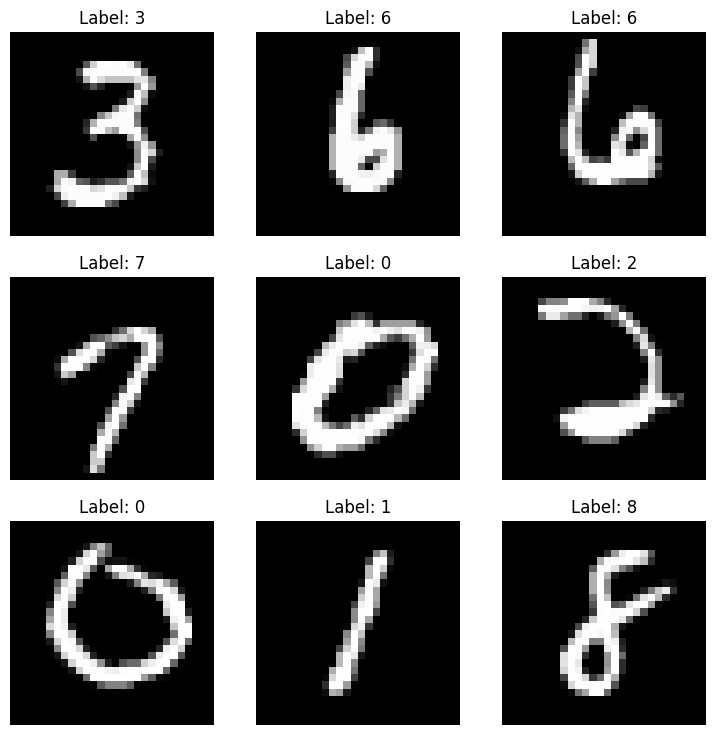

In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.show()

#Define model

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.linear4(x)
        return x

model = MLP().to(device)

In [5]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.linear1.register_forward_hook(get_activation('linear1'))
model.linear2.register_forward_hook(get_activation('linear2'))
model.linear3.register_forward_hook(get_activation('linear3'))
model.linear4.register_forward_hook(get_activation('linear4'))

In [6]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model

In [7]:
training_epochs = 20
model.train()
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(train_loader)

    for X, Y in train_loader:
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.390233278
Epoch: 0002 cost = 0.147415668
Epoch: 0003 cost = 0.107286155
Epoch: 0004 cost = 0.086875103
Epoch: 0005 cost = 0.072013266
Epoch: 0006 cost = 0.064012334
Epoch: 0007 cost = 0.057913054
Epoch: 0008 cost = 0.050299887
Epoch: 0009 cost = 0.047034856
Epoch: 0010 cost = 0.042937189
Epoch: 0011 cost = 0.041456249
Epoch: 0012 cost = 0.038476668
Epoch: 0013 cost = 0.035523083
Epoch: 0014 cost = 0.033729076
Epoch: 0015 cost = 0.034216594
Epoch: 0016 cost = 0.030844161
Epoch: 0017 cost = 0.028954778
Epoch: 0018 cost = 0.028134672
Epoch: 0019 cost = 0.026843203
Epoch: 0020 cost = 0.025419131
Learning finished


# eval model & similarities matrix

In [9]:
for name, module in model.named_modules():
    print(name, module)

 MLP(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)
linear1 Linear(in_features=784, out_features=512, bias=True)
linear2 Linear(in_features=512, out_features=256, bias=True)
linear3 Linear(in_features=256, out_features=128, bias=True)
linear4 Linear(in_features=128, out_features=10, bias=True)
dropout Dropout(p=0.3, inplace=False)
relu ReLU()


In [14]:
def compute_similarity(activation):
    similarities = {}
    for name, activations in activation.items():
        if activations.ndim > 2:
            activations = activations.reshape(activations.shape[0], -1)  # Flatten

        sampled_activations = activations[:10]
        similarity_matrix = cosine_similarity(sampled_activations)
        similarities[name] = similarity_matrix
    return similarities

model.eval()
with torch.no_grad():
    test_activations = {}
    for X, Y in test_loader:
        X = X.view(-1, 28 * 28).to(device)
        _ = model(X)
        for name in activation:
            if name not in test_activations:
                test_activations[name] = activation[name].cpu().numpy()
            else:
                test_activations[name] = np.vstack((test_activations[name], activation[name].cpu().numpy()))


similarities = compute_similarity(test_activations)

# visualize similarity matrix

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer linear1:
[[0.99999994 0.40264225 0.65487343 0.4724443  0.550421   0.5302015
  0.94966316 0.6564989  0.59790784 0.9698831 ]
 [0.40264225 1.0000004  0.49453872 0.57993907 0.62079513 0.5379833
  0.47206593 0.45740634 0.60020554 0.3074172 ]
 [0.65487343 0.49453872 1.0000001  0.45570186 0.4683864  0.53425545
  0.65815663 0.56682825 0.62474024 0.60243297]
 [0.4724443  0.57993907 0.45570186 1.0000002  0.74776506 0.6944593
  0.56239927 0.73924756 0.66719925 0.42040962]
 [0.550421   0.62079513 0.4683864  0.74776506 1.0000002  0.57504976
  0.5900688  0.5840601  0.4941191  0.49156725]
 [0.5302015  0.5379833  0.53425545 0.6944593  0.57504976 0.99999976
  0.62022334 0.8359753  0.5256928  0.50299954]
 [0.94966316 0.47206593 0.65815663 0.56239927 0.5900688  0.62022334
  1.         0.73215854 0.63853884 0.8897651 ]
 [0.6564989  0.45740634 0.56682825 0.73924756 0.5840601  0.8359753
  0.73215854 1.0000002  0.71986866 0.6544045 ]
 [0.59790784 0.60020554 0.62474024 0.66719925 0

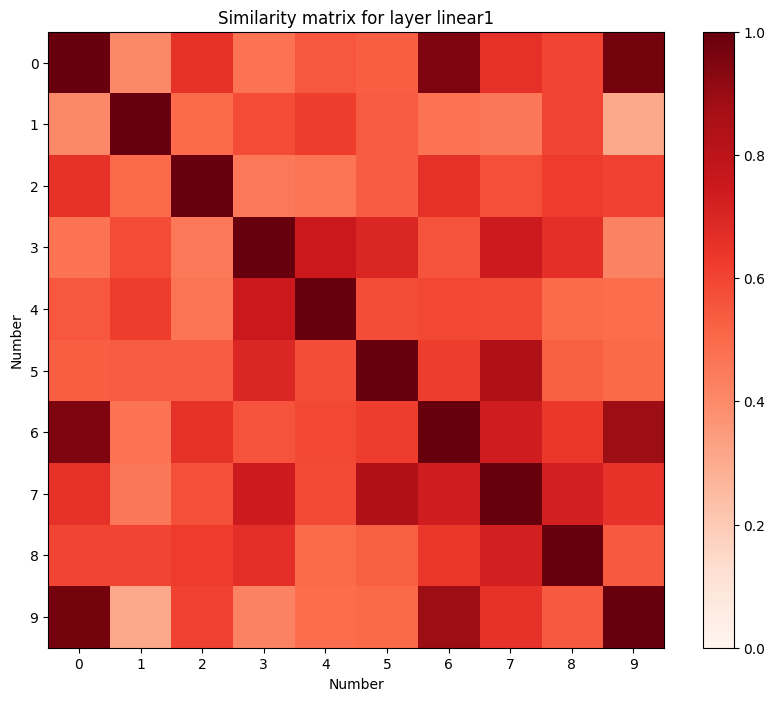

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer linear2:
[[ 1.          0.30177358  0.7504513   0.4975172   0.4736368   0.11710429
   0.76214665  0.33798376  0.20730798  0.9682383 ]
 [ 0.30177358  1.0000001   0.23900633  0.32205126  0.45134726 -0.09814557
   0.32078016  0.11372221 -0.02994903  0.24003562]
 [ 0.7504513   0.23900633  0.99999976  0.23418057  0.21625578  0.21919191
   0.60648316  0.20330751  0.2094927   0.7882481 ]
 [ 0.4975172   0.32205126  0.23418057  0.99999964  0.8228765   0.30472597
   0.33239433  0.5595028   0.40384245  0.39555204]
 [ 0.4736368   0.45134726  0.21625578  0.8228765   0.9999998   0.12945175
   0.23050435  0.31596917  0.3597076   0.4077268 ]
 [ 0.11710429 -0.09814557  0.21919191  0.30472597  0.12945175  1.0000002
   0.19814245  0.45860958  0.49455446  0.08799048]
 [ 0.76214665  0.32078016  0.60648316  0.33239433  0.23050435  0.19814245
   0.9999997   0.6331699   0.21864727  0.6784806 ]
 [ 0.33798376  0.11372221  0.20330751  0.5595028   0.31596917  0.45860958
   0.6331699   

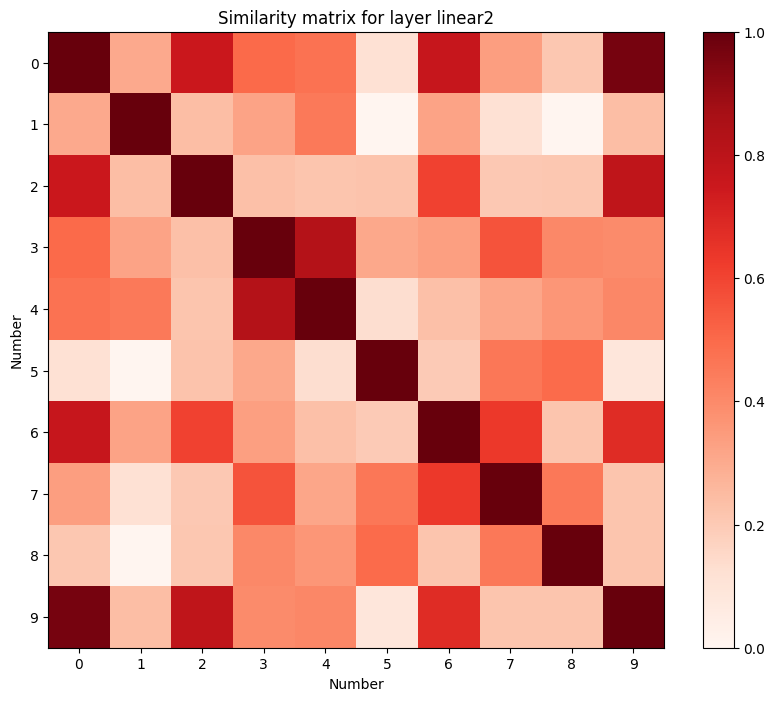

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer linear3:
[[ 1.00000012e+00  2.68507063e-01  9.06456053e-01  2.61475563e-01
   2.20878184e-01 -2.28304476e-01  7.45416880e-01  1.35166705e-01
  -1.51963234e-01  9.82515931e-01]
 [ 2.68507063e-01  1.00000024e+00  1.87591553e-01  8.19434524e-02
   1.77181065e-01 -2.43768811e-01  2.43647277e-01  6.25231788e-02
  -2.75154799e-01  2.41967559e-01]
 [ 9.06456053e-01  1.87591553e-01  1.00000036e+00 -1.26552608e-04
   1.31111825e-02 -8.37927908e-02  6.81203663e-01  9.28860903e-02
   1.46016637e-02  9.38311279e-01]
 [ 2.61475563e-01  8.19434524e-02 -1.26552608e-04  9.99999821e-01
   9.44069743e-01 -1.17092349e-01  8.10734183e-02  2.52945811e-01
   1.02882832e-01  2.16491774e-01]
 [ 2.20878184e-01  1.77181065e-01  1.31111825e-02  9.44069743e-01
   9.99999702e-01 -2.21116394e-01 -6.69425800e-02  8.62903297e-02
   1.92633897e-01  2.12376982e-01]
 [-2.28304476e-01 -2.43768811e-01 -8.37927908e-02 -1.17092349e-01
  -2.21116394e-01  9.99999881e-01 -2.04910692e-02  2.90340871e

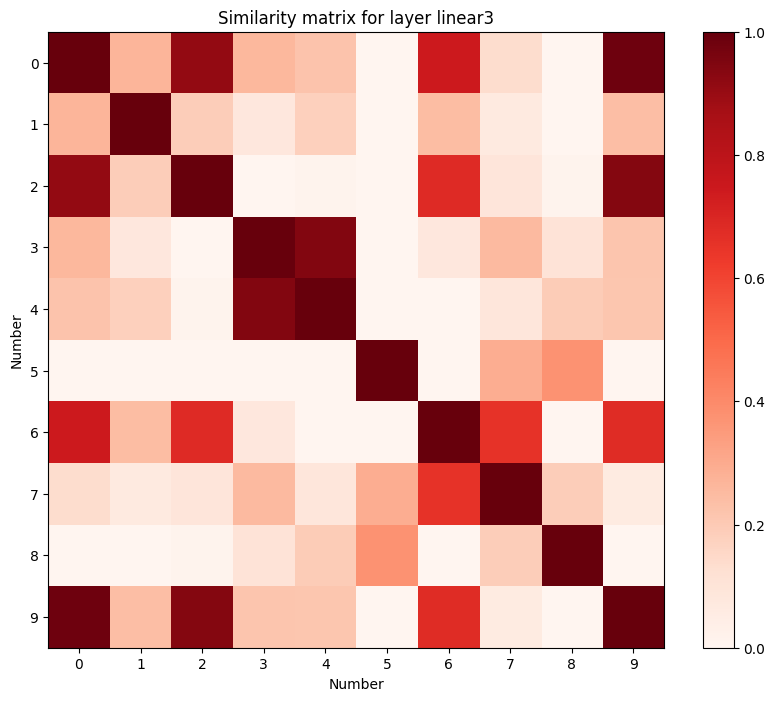

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer linear4:
[[ 1.0000001   0.34447917  0.95159954  0.5149458   0.52952677  0.05652913
   0.88695365  0.2464587   0.06769905  0.9876569 ]
 [ 0.34447917  1.0000001   0.2520769   0.18190014  0.2565746  -0.09856506
   0.3536282   0.11255935 -0.15223524  0.2740549 ]
 [ 0.95159954  0.2520769   1.          0.42538697  0.45315894  0.23400527
   0.8456389   0.26359612  0.22955267  0.96848965]
 [ 0.5149458   0.18190014  0.42538697  0.99999994  0.9585544   0.35716337
   0.38461313  0.6001196   0.5381877   0.5453734 ]
 [ 0.52952677  0.2565746   0.45315894  0.9585544   1.          0.25146884
   0.3162308   0.43341884  0.5427572   0.57571274]
 [ 0.05652913 -0.09856506  0.23400527  0.35716337  0.25146884  1.0000001
   0.13840547  0.5765935   0.71916     0.10693242]
 [ 0.88695365  0.3536282   0.8456389   0.38461313  0.3162308   0.13840547
   1.          0.5085371   0.05348226  0.8517584 ]
 [ 0.2464587   0.11255935  0.26359612  0.6001196   0.43341884  0.5765935
   0.5085371   1

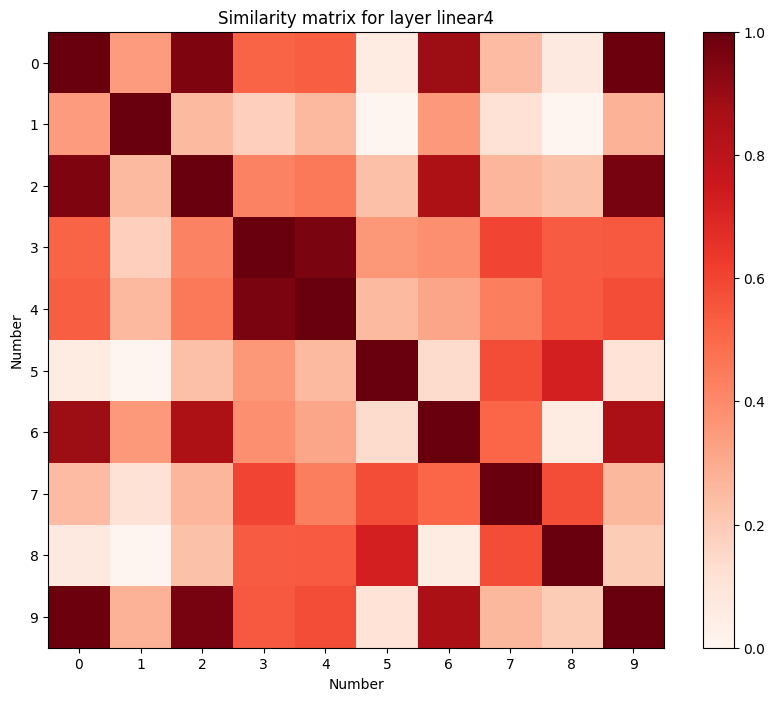

In [19]:
import pandas as pd
from google.colab import files

for name, similarity_matrix in similarities.items():
    csv_filename = f'similarity_{name}.csv'
    df = pd.DataFrame(similarity_matrix)  # Convert to DataFrame
    df.to_csv(csv_filename, index=False, header=False)  # Save as CSV

    # Trigger file download
    files.download(csv_filename)

    print(f'Similarity matrix for layer {name}:')
    print(similarity_matrix)
    plt.figure(figsize=(10, 8))
    tick_marks = list(range(10))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Number')
    plt.ylabel('Number')
    plt.title(f'Similarity matrix for layer {name}')
    plt.imshow(similarity_matrix, cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f'similarity_{name}.png')
    plt.show()
    plt.close()

In [12]:
from sklearn.metrics.pairwise import manhattan_distances
#calculate similarity matrix with laplacian_kernel method
def compute_laplacian_kernel(activation, sigma=1.0):
    similarities = {}
    for name, activations in activation.items():
        if activations.ndim > 2:
            activations = activations.reshape(activations.shape[0], -1)  # Flatten

        # Use a subset of activations for similarity computation
        sampled_activations = activations[:10]

        # Compute Manhattan distances
        manhattan_dists = manhattan_distances(sampled_activations)

        # Compute Laplacian kernel similarity
        similarity_matrix = np.exp(-manhattan_dists / sigma)
        similarities[name] = similarity_matrix
    return similarities


model.eval()
with torch.no_grad():
    test_activations = {}
    for X, Y in test_loader:
        X = X.view(-1, 28 * 28).to(device)
        _ = model(X)
        for name in activation:
            if name not in test_activations:
                test_activations[name] = activation[name].cpu().numpy()
            else:
                test_activations[name] = np.vstack((test_activations[name], activation[name].cpu().numpy()))


similarities = compute_laplacian_kernel(test_activations)

Similarity matrix for layer linear1:
[[1.00000000e+000 0.00000000e+000 2.89195453e-299 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  3.88307281e-234 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.89195453e-299 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  5.83513127e-261 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 3.96282909e-

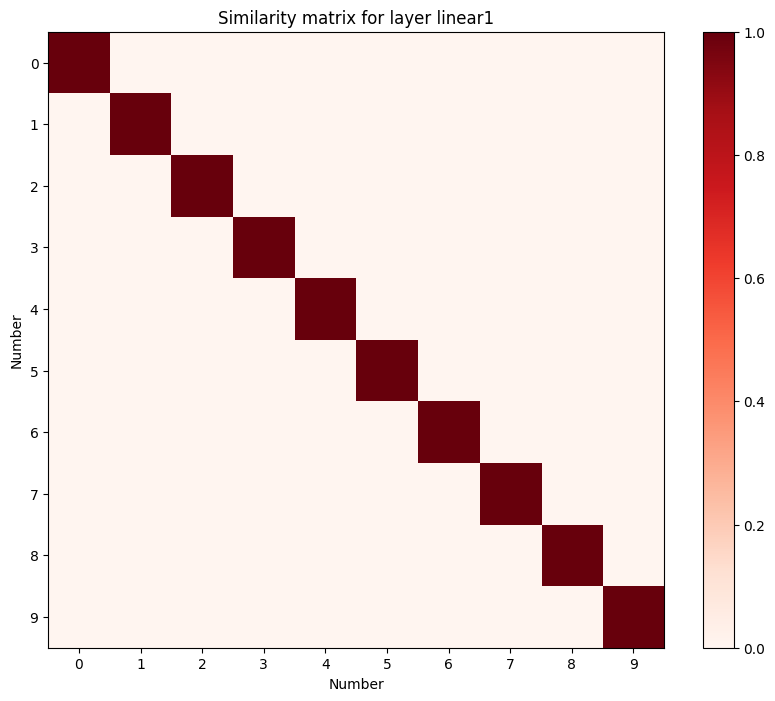

Similarity matrix for layer linear2:
[[1.00000000e+000 0.00000000e+000 4.22932373e-091 7.37343570e-320
  1.96841417e-261 6.40568759e-260 3.40881004e-282 7.88167585e-242
  1.52981402e-147 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 1.01186364e-161]
 [4.22932373e-091 0.00000000e+000 1.00000000e+000 3.21666702e-272
  1.29442355e-269 1.49443564e-230 2.71572031e-304 1.08471470e-217
  2.78339685e-146 0.00000000e+000]
 [7.37343570e-320 0.00000000e+000 3.21666702e-272 1.00000000e+000
  6.27380936e-303 1.22993158e-266 0.00000000e+000 5.49783815e-294
  1.55933031e-268 0.00000000e+000]
 [1.96841417e-261 0.00000000e+000 1.29442355e-269 6.27380936e-303
  1.00000000e+000 1.87236551e-302 4.59890605e-122 3.14205988e-319
  2.55030534e-150 0.00000000e+000]
 [6.40568759e-260 0.00000000e+000 1.49443564e-230 1.22993158e-266
  1.87236551e-302 1.00000000e+000 0.00000000e+000 7.99093093e-

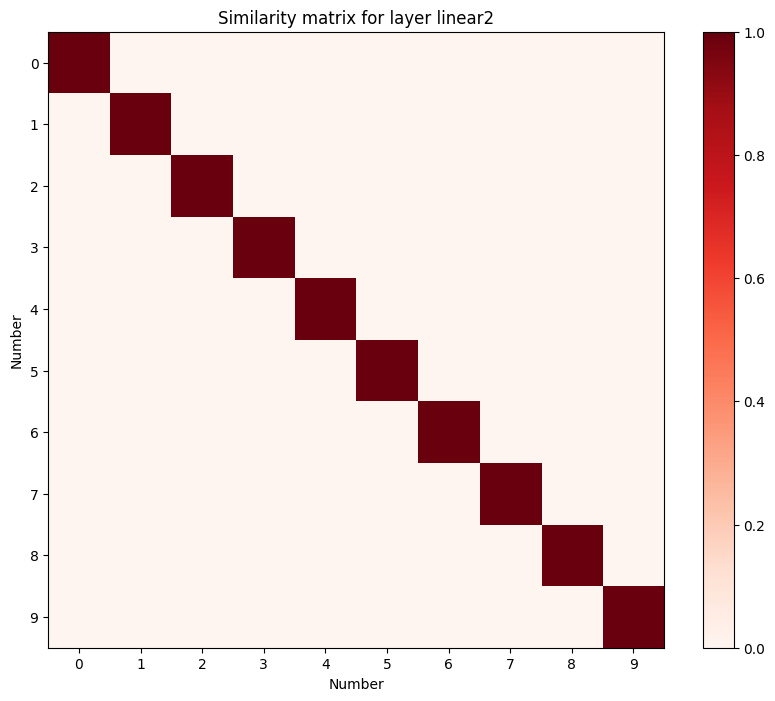

Similarity matrix for layer linear3:
[[1.00000000e+000 0.00000000e+000 2.88892221e-100 1.15451830e-311
  0.00000000e+000 2.69905625e-267 0.00000000e+000 3.60292411e-285
  4.75127851e-179 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 2.04504064e-079]
 [2.88892221e-100 0.00000000e+000 1.00000000e+000 1.17264916e-250
  0.00000000e+000 4.66606124e-229 0.00000000e+000 2.37655642e-258
  2.80588348e-170 0.00000000e+000]
 [1.15451830e-311 0.00000000e+000 1.17264916e-250 1.00000000e+000
  0.00000000e+000 5.50909984e-282 0.00000000e+000 4.96585432e-313
  3.85164941e-288 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000 0.00000000e+000 1.31781319e-066 0.00000000e+000
  3.32618285e-180 0.00000000e+000]
 [2.69905625e-267 0.00000000e+000 4.66606124e-229 5.50909984e-282
  0.00000000e+000 1.00000000e+000 0.00000000e+000 3.20981497e-

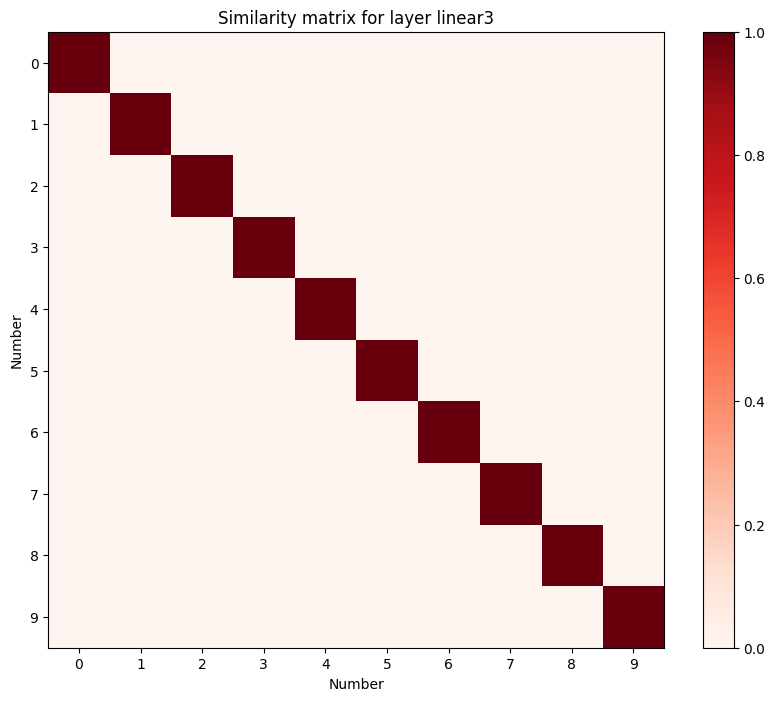

Similarity matrix for layer linear4:
[[1.00000000e+00 4.23860276e-59 8.56317880e-19 2.30412404e-45
  8.35489474e-52 6.05459499e-43 3.18695527e-58 1.28738734e-43
  1.27540235e-26 3.66965434e-52]
 [4.23860276e-59 1.00000000e+00 6.00325052e-61 9.31460086e-66
  3.29992637e-88 1.12934441e-63 2.82709291e-89 7.35504884e-64
  5.04284764e-75 2.20855516e-10]
 [8.56317880e-19 6.00325052e-61 1.00000000e+00 2.69531531e-38
  9.97314308e-57 2.05446090e-38 2.40826379e-63 1.06724779e-40
  1.80828975e-27 2.71060030e-53]
 [2.30412404e-45 9.31460086e-66 2.69531531e-38 1.00000000e+00
  6.91608888e-63 1.24527076e-31 1.14611806e-68 1.91118114e-34
  1.15840106e-43 5.39320770e-61]
 [8.35489474e-52 3.29992637e-88 9.97314308e-57 6.91608888e-63
  1.00000000e+00 6.06021477e-67 1.48719988e-10 9.54229337e-65
  6.88881522e-33 1.88511802e-85]
 [6.05459499e-43 1.12934441e-63 2.05446090e-38 1.24527076e-31
  6.06021477e-67 1.00000000e+00 3.02367939e-75 3.51746255e-05
  2.96045251e-44 1.27867886e-55]
 [3.18695527e-58 2.82

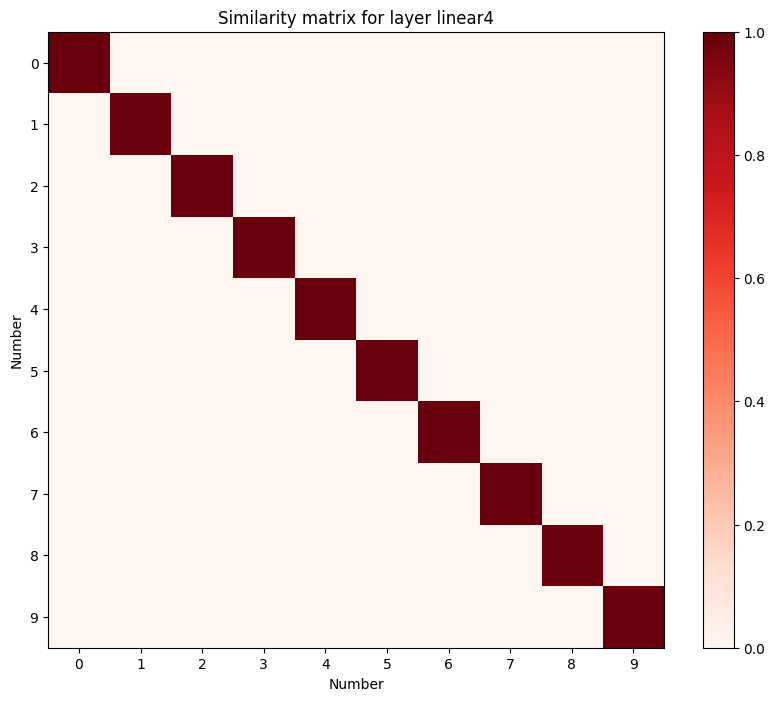

In [13]:
for name, similarity_matrix in similarities.items():
    print(f'Similarity matrix for layer {name}:')
    print(similarity_matrix)
    plt.figure(figsize=(10, 8))
    tick_marks = list(range(10))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Number')
    plt.ylabel('Number')
    plt.title(f'Similarity matrix for layer {name}')
    plt.imshow(similarity_matrix, cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f'similarity_{name}.png')
    plt.show()
    plt.close()